<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Для начала установим и загрузим все необходимые библиотеки и посмотрим на наши данные. 

In [1]:
#Install and import all necessary libraries
!pip install pandas
import pandas as pd
from collections import Counter
!pip install matplotlib
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
!pip install scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
!pip install fast_ml
from fast_ml.model_development import train_valid_test_split
!pip install catboost
import catboost as ctb
!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Load data
filepath = 'https://github.com/Viktoriia-Ilina/yandex/blob/main/Churn_Modelling.csv?raw=true'
data = pd.read_csv(filepath)
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Итак у нас есть следующая информация о 10000 клиентов банка:

- RowNumber — индекс строки в данных;
- CustomerId — уникальный идентификатор клиента;
- Surname — фамилия;
- CreditScore — кредитный рейтинг;
- Geography — страна проживания;
- Gender — пол;
- Age — возраст;
- Tenure — сколько лет человек является клиентом банка;
- Balance — баланс на счёте;
- NumOfProducts — количество продуктов банка, используемых клиентом;
- HasCrCard — наличие кредитной карты;
- IsActiveMember — активность клиента;
- EstimatedSalary — предполагаемая зарплата.

И целевой показатедь Exited, обозначающий ушел клиент или остался. 

В целях дальнейшего анализа столбцы 'RowNumber', 'CustomerId' и 'Surname' малоинформативны, поэтому мы можем их удалить. 


In [2]:
data = data.drop(['RowNumber', 'Surname', 'CustomerId'], axis = 'columns')
data.tail()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


Теперь проверим нащи данные на наличие отсутствующих значений и дубликаты.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [4]:
data.duplicated().sum()

0

Отлично, можем двигаться дальше. 

## Исследование задачи

Заменим текстовые значения в стобцах 'Geography' и 'Gender' на числовые.

In [5]:
lb = LabelEncoder() 

data['Geography'] = lb.fit_transform(data['Geography'])
data['Gender'] = lb.fit_transform(data['Gender'])

data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


Построим корреляционную матрицу и посмотрим какие переменные наиболее тесно связаны с таргетной переменной. 

<AxesSubplot:>

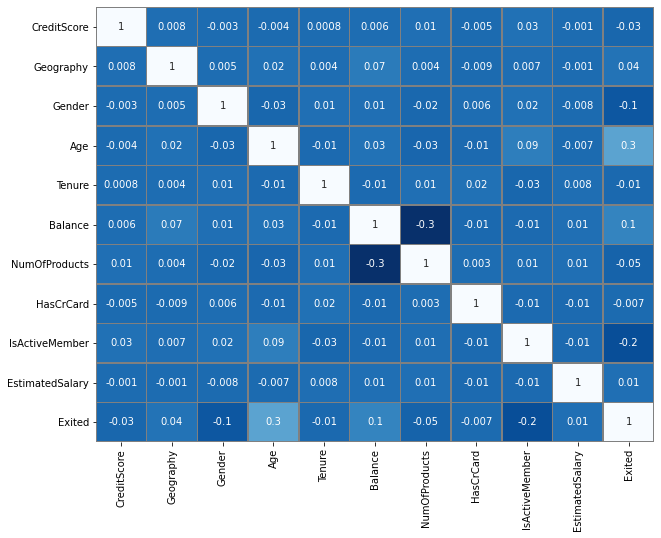

In [6]:
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(data.corr(), annot = True, fmt = '.1g', cmap = 'Blues_r', cbar = False, linewidths = 0.5, linecolor = 'grey')

Наибольшая корреляция (0.3) наблюдается между возрастом и целевым значением. Это немного странно, так как обычно когда люди становятся старше, они теряют тягу к риску и предпочитают стабильность. Присутствует отрицательная корреляция (-0.2) между активностью пользователя и его желанием отказаться от услуг банка. В то же время наблюдается слабая положительная корреляция между балансом на счёте и таргетной переменной (0.1). В целом все корреляции являются слабыми.

Посмотрим на сбалансированность датасета. Мы видим большой перекос в сторону клиентов, остающихся с банком (80% против 20%). Это типичная проблема в подобного рода задачах и обычно она решается с помощью корректировки данных (undersampling, oversampling, добавление новых реальных данных и т.д.). Однако для начала попробуем произвести расчёты как есть.

In [7]:
data['Exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Для того чтобы избежать проблемы переобучения модели, разделим наши данные на три группы: обучение, проверка и тестирование.

In [41]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = train_valid_test_split(data, target = 'Exited', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state = 77)

print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(8000, 10)
(8000,)
(1000, 10)
(1000,)
(1000, 10)
(1000,)


(None, None)

Так наши переменные имеют разные шкалы и отличаются в тысячи раз, то они вносят разный вклад в процесс обучения модели, что может в конечном итоге создать предвзятость. Чтобы этого избежать применим Standard Scaler.

In [42]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

В ходе данного проекта мы будем использовать три модели:
- Support vector classifier;
- Random forest classifier;
- Catboost.

Для оценки будут использоваться:
- classification report;
- confusion_matrix; 
- roc - auc score.

### Support Vector Classifier

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       786
           1       0.77      0.38      0.51       214

    accuracy                           0.84      1000
   macro avg       0.81      0.68      0.71      1000
weighted avg       0.84      0.84      0.82      1000

AUC - ROC score:  0.6763216094742098


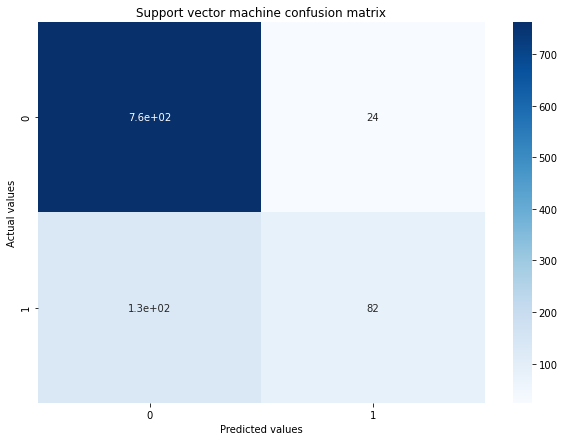

In [20]:
SVM = SVC(random_state = 1)
SVM.fit(X_train, Y_train)
Y_pred = SVM.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Support vector machine confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       786
           1       0.73      0.48      0.58       214

    accuracy                           0.85      1000
   macro avg       0.80      0.71      0.74      1000
weighted avg       0.84      0.85      0.84      1000

AUC - ROC score:  0.7141447290195239


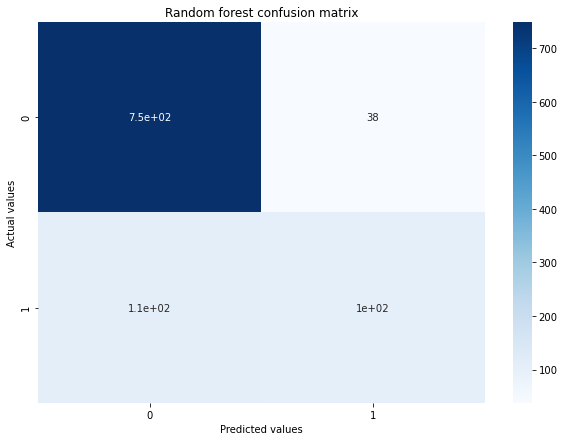

In [21]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random forest confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

### Catboost

Learning rate set to 0.025035
0:	learn: 0.6731781	total: 2.08ms	remaining: 2.07s
1:	learn: 0.6541255	total: 3.83ms	remaining: 1.91s
2:	learn: 0.6363677	total: 5.68ms	remaining: 1.89s
3:	learn: 0.6189211	total: 7.69ms	remaining: 1.92s
4:	learn: 0.6029321	total: 9.64ms	remaining: 1.92s
5:	learn: 0.5888791	total: 11.5ms	remaining: 1.9s
6:	learn: 0.5743036	total: 13.4ms	remaining: 1.91s
7:	learn: 0.5629785	total: 15.3ms	remaining: 1.89s
8:	learn: 0.5501886	total: 17.2ms	remaining: 1.89s
9:	learn: 0.5386719	total: 19.1ms	remaining: 1.89s
10:	learn: 0.5284524	total: 20.8ms	remaining: 1.87s
11:	learn: 0.5196107	total: 22.7ms	remaining: 1.87s
12:	learn: 0.5110456	total: 24.5ms	remaining: 1.86s
13:	learn: 0.5035970	total: 26.3ms	remaining: 1.85s
14:	learn: 0.4950389	total: 28.2ms	remaining: 1.85s
15:	learn: 0.4874511	total: 30.2ms	remaining: 1.85s
16:	learn: 0.4797868	total: 32.2ms	remaining: 1.86s
17:	learn: 0.4726832	total: 34.3ms	remaining: 1.87s
18:	learn: 0.4671598	total: 36.3ms	remaining:

194:	learn: 0.3134147	total: 385ms	remaining: 1.59s
195:	learn: 0.3132585	total: 387ms	remaining: 1.59s
196:	learn: 0.3130272	total: 390ms	remaining: 1.59s
197:	learn: 0.3129230	total: 393ms	remaining: 1.59s
198:	learn: 0.3127380	total: 395ms	remaining: 1.59s
199:	learn: 0.3125700	total: 397ms	remaining: 1.59s
200:	learn: 0.3123149	total: 399ms	remaining: 1.59s
201:	learn: 0.3120462	total: 401ms	remaining: 1.58s
202:	learn: 0.3119396	total: 403ms	remaining: 1.58s
203:	learn: 0.3118488	total: 405ms	remaining: 1.58s
204:	learn: 0.3116839	total: 408ms	remaining: 1.58s
205:	learn: 0.3115196	total: 410ms	remaining: 1.58s
206:	learn: 0.3113176	total: 412ms	remaining: 1.58s
207:	learn: 0.3111915	total: 414ms	remaining: 1.58s
208:	learn: 0.3110435	total: 417ms	remaining: 1.58s
209:	learn: 0.3108957	total: 419ms	remaining: 1.57s
210:	learn: 0.3107749	total: 421ms	remaining: 1.57s
211:	learn: 0.3106181	total: 423ms	remaining: 1.57s
212:	learn: 0.3105087	total: 425ms	remaining: 1.57s
213:	learn: 

367:	learn: 0.2915913	total: 772ms	remaining: 1.33s
368:	learn: 0.2914916	total: 775ms	remaining: 1.32s
369:	learn: 0.2913958	total: 777ms	remaining: 1.32s
370:	learn: 0.2912199	total: 779ms	remaining: 1.32s
371:	learn: 0.2910975	total: 781ms	remaining: 1.32s
372:	learn: 0.2909675	total: 783ms	remaining: 1.32s
373:	learn: 0.2908742	total: 785ms	remaining: 1.31s
374:	learn: 0.2907851	total: 787ms	remaining: 1.31s
375:	learn: 0.2906495	total: 789ms	remaining: 1.31s
376:	learn: 0.2905027	total: 792ms	remaining: 1.31s
377:	learn: 0.2903392	total: 794ms	remaining: 1.31s
378:	learn: 0.2902091	total: 796ms	remaining: 1.3s
379:	learn: 0.2900908	total: 798ms	remaining: 1.3s
380:	learn: 0.2900190	total: 801ms	remaining: 1.3s
381:	learn: 0.2898127	total: 803ms	remaining: 1.3s
382:	learn: 0.2896567	total: 805ms	remaining: 1.3s
383:	learn: 0.2895583	total: 807ms	remaining: 1.29s
384:	learn: 0.2894541	total: 809ms	remaining: 1.29s
385:	learn: 0.2893331	total: 811ms	remaining: 1.29s
386:	learn: 0.289

545:	learn: 0.2722089	total: 1.16s	remaining: 965ms
546:	learn: 0.2721448	total: 1.16s	remaining: 963ms
547:	learn: 0.2720480	total: 1.17s	remaining: 961ms
548:	learn: 0.2719615	total: 1.17s	remaining: 959ms
549:	learn: 0.2718158	total: 1.17s	remaining: 957ms
550:	learn: 0.2717557	total: 1.17s	remaining: 954ms
551:	learn: 0.2716886	total: 1.17s	remaining: 952ms
552:	learn: 0.2716097	total: 1.18s	remaining: 950ms
553:	learn: 0.2715056	total: 1.18s	remaining: 948ms
554:	learn: 0.2714680	total: 1.18s	remaining: 946ms
555:	learn: 0.2713883	total: 1.18s	remaining: 944ms
556:	learn: 0.2712902	total: 1.18s	remaining: 942ms
557:	learn: 0.2711520	total: 1.19s	remaining: 939ms
558:	learn: 0.2710413	total: 1.19s	remaining: 937ms
559:	learn: 0.2709255	total: 1.19s	remaining: 936ms
560:	learn: 0.2708142	total: 1.19s	remaining: 934ms
561:	learn: 0.2707455	total: 1.2s	remaining: 932ms
562:	learn: 0.2706494	total: 1.2s	remaining: 929ms
563:	learn: 0.2705558	total: 1.2s	remaining: 927ms
564:	learn: 0.2

727:	learn: 0.2557691	total: 1.54s	remaining: 577ms
728:	learn: 0.2556948	total: 1.55s	remaining: 575ms
729:	learn: 0.2556386	total: 1.55s	remaining: 573ms
730:	learn: 0.2555862	total: 1.55s	remaining: 571ms
731:	learn: 0.2554856	total: 1.55s	remaining: 569ms
732:	learn: 0.2554174	total: 1.55s	remaining: 566ms
733:	learn: 0.2553344	total: 1.56s	remaining: 564ms
734:	learn: 0.2552386	total: 1.56s	remaining: 562ms
735:	learn: 0.2551618	total: 1.56s	remaining: 560ms
736:	learn: 0.2550849	total: 1.56s	remaining: 558ms
737:	learn: 0.2550227	total: 1.56s	remaining: 555ms
738:	learn: 0.2548936	total: 1.57s	remaining: 553ms
739:	learn: 0.2548041	total: 1.57s	remaining: 551ms
740:	learn: 0.2547061	total: 1.57s	remaining: 549ms
741:	learn: 0.2546451	total: 1.57s	remaining: 547ms
742:	learn: 0.2545772	total: 1.57s	remaining: 544ms
743:	learn: 0.2545070	total: 1.57s	remaining: 542ms
744:	learn: 0.2543601	total: 1.58s	remaining: 540ms
745:	learn: 0.2542675	total: 1.58s	remaining: 538ms
746:	learn: 

927:	learn: 0.2398977	total: 1.93s	remaining: 150ms
928:	learn: 0.2397982	total: 1.93s	remaining: 148ms
929:	learn: 0.2397021	total: 1.94s	remaining: 146ms
930:	learn: 0.2396059	total: 1.94s	remaining: 144ms
931:	learn: 0.2395288	total: 1.94s	remaining: 142ms
932:	learn: 0.2394586	total: 1.94s	remaining: 139ms
933:	learn: 0.2393931	total: 1.94s	remaining: 137ms
934:	learn: 0.2393198	total: 1.95s	remaining: 135ms
935:	learn: 0.2392094	total: 1.95s	remaining: 133ms
936:	learn: 0.2391510	total: 1.95s	remaining: 131ms
937:	learn: 0.2390411	total: 1.95s	remaining: 129ms
938:	learn: 0.2389613	total: 1.95s	remaining: 127ms
939:	learn: 0.2388552	total: 1.96s	remaining: 125ms
940:	learn: 0.2388024	total: 1.96s	remaining: 123ms
941:	learn: 0.2387177	total: 1.96s	remaining: 121ms
942:	learn: 0.2386115	total: 1.96s	remaining: 119ms
943:	learn: 0.2385618	total: 1.96s	remaining: 116ms
944:	learn: 0.2384737	total: 1.97s	remaining: 114ms
945:	learn: 0.2383798	total: 1.97s	remaining: 112ms
946:	learn: 

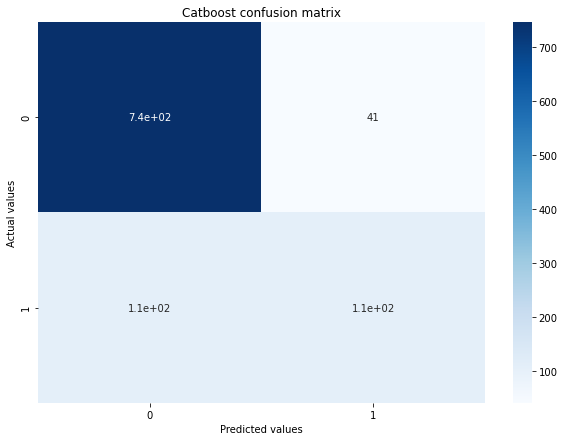

In [43]:
model_CBC = ctb.CatBoostClassifier(random_state=1)
model_CBC.fit(X_train, Y_train)
Y_pred = model_CBC.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Catboost confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

Все три модели имеют высокую точность 84-85%, однако в данной ситуации (несбалансированность датасета) метрика точности является необъективной, так как модели хорошо определяют класс большинства и очень плохо работают для меньшинства. Особенно сильно это проявляется у Support Vector Classifier, где показатель F1 составил 51%. 

## Борьба с дисбалансом

### SMOTE

Для того чтобы справиться с проблемой несбалансированного датасета применим технику SMOTE, которая генерирует дополнительные синтетические значения для меньшинства.

In [44]:
counter = Counter(Y_train)
print('Inintial training data',counter)
smote = SMOTE()
X_train,Y_train = smote.fit_resample(X_train,Y_train)
counter = Counter(Y_train)
print('After resampling',counter)

Inintial training data Counter({0: 6363, 1: 1637})
After resampling Counter({0: 6363, 1: 6363})


              precision    recall  f1-score   support

           0       0.91      0.79      0.85       786
           1       0.48      0.71      0.57       214

    accuracy                           0.78      1000
   macro avg       0.70      0.75      0.71      1000
weighted avg       0.82      0.78      0.79      1000

AUC - ROC score:  0.7497503032032532


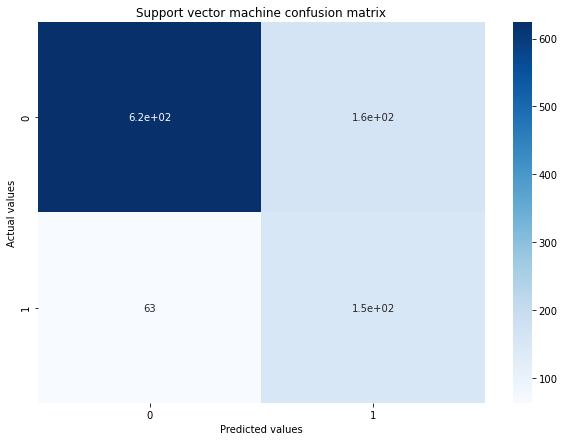

In [45]:
SVM = SVC(random_state = 1)
SVM.fit(X_train, Y_train)
Y_pred = SVM.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Support vector machine confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       786
           1       0.59      0.59      0.59       214

    accuracy                           0.83      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.83      0.83      0.83      1000

AUC - ROC score:  0.7413854605122351


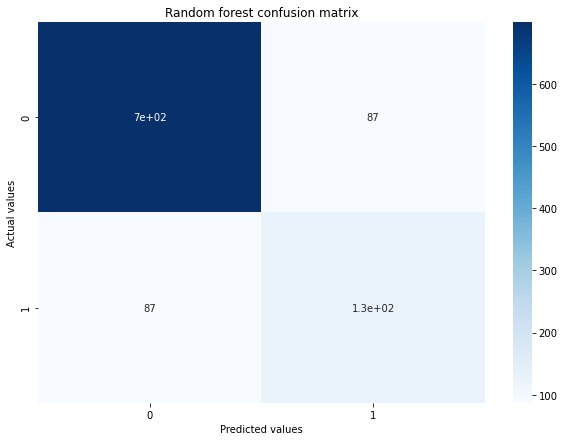

In [46]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random forest confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

Learning rate set to 0.030524
0:	learn: 0.6761729	total: 4.02ms	remaining: 4.02s
1:	learn: 0.6595590	total: 7.46ms	remaining: 3.72s
2:	learn: 0.6444414	total: 11.1ms	remaining: 3.7s
3:	learn: 0.6295006	total: 15.4ms	remaining: 3.83s
4:	learn: 0.6171899	total: 19ms	remaining: 3.78s
5:	learn: 0.6064128	total: 22.4ms	remaining: 3.71s
6:	learn: 0.5945278	total: 26ms	remaining: 3.69s
7:	learn: 0.5833059	total: 29.9ms	remaining: 3.71s
8:	learn: 0.5732507	total: 33.9ms	remaining: 3.73s
9:	learn: 0.5634881	total: 38.1ms	remaining: 3.77s
10:	learn: 0.5546382	total: 42.3ms	remaining: 3.8s
11:	learn: 0.5458450	total: 46.2ms	remaining: 3.81s
12:	learn: 0.5388566	total: 50.8ms	remaining: 3.86s
13:	learn: 0.5324208	total: 54.7ms	remaining: 3.85s
14:	learn: 0.5261798	total: 58.6ms	remaining: 3.85s
15:	learn: 0.5201258	total: 62.3ms	remaining: 3.83s
16:	learn: 0.5156284	total: 66.1ms	remaining: 3.82s
17:	learn: 0.5114118	total: 69.6ms	remaining: 3.8s
18:	learn: 0.5069985	total: 73.1ms	remaining: 3.77s

162:	learn: 0.3238622	total: 589ms	remaining: 3.03s
163:	learn: 0.3235726	total: 593ms	remaining: 3.02s
164:	learn: 0.3234074	total: 596ms	remaining: 3.02s
165:	learn: 0.3217509	total: 600ms	remaining: 3.01s
166:	learn: 0.3214151	total: 603ms	remaining: 3.01s
167:	learn: 0.3206115	total: 606ms	remaining: 3s
168:	learn: 0.3202981	total: 610ms	remaining: 3s
169:	learn: 0.3197171	total: 613ms	remaining: 2.99s
170:	learn: 0.3193864	total: 617ms	remaining: 2.99s
171:	learn: 0.3189550	total: 620ms	remaining: 2.98s
172:	learn: 0.3184499	total: 623ms	remaining: 2.98s
173:	learn: 0.3177746	total: 627ms	remaining: 2.98s
174:	learn: 0.3173202	total: 631ms	remaining: 2.97s
175:	learn: 0.3168774	total: 635ms	remaining: 2.97s
176:	learn: 0.3149675	total: 639ms	remaining: 2.97s
177:	learn: 0.3140230	total: 642ms	remaining: 2.97s
178:	learn: 0.3136888	total: 647ms	remaining: 2.97s
179:	learn: 0.3130089	total: 650ms	remaining: 2.96s
180:	learn: 0.3126242	total: 656ms	remaining: 2.97s
181:	learn: 0.3108

326:	learn: 0.2568136	total: 1.18s	remaining: 2.42s
327:	learn: 0.2564139	total: 1.18s	remaining: 2.42s
328:	learn: 0.2562083	total: 1.18s	remaining: 2.41s
329:	learn: 0.2559061	total: 1.19s	remaining: 2.41s
330:	learn: 0.2548002	total: 1.19s	remaining: 2.4s
331:	learn: 0.2546597	total: 1.19s	remaining: 2.4s
332:	learn: 0.2544017	total: 1.2s	remaining: 2.4s
333:	learn: 0.2542439	total: 1.2s	remaining: 2.4s
334:	learn: 0.2541399	total: 1.21s	remaining: 2.39s
335:	learn: 0.2535448	total: 1.21s	remaining: 2.39s
336:	learn: 0.2534050	total: 1.21s	remaining: 2.38s
337:	learn: 0.2532412	total: 1.22s	remaining: 2.38s
338:	learn: 0.2528935	total: 1.22s	remaining: 2.38s
339:	learn: 0.2527428	total: 1.22s	remaining: 2.38s
340:	learn: 0.2525957	total: 1.23s	remaining: 2.37s
341:	learn: 0.2524321	total: 1.23s	remaining: 2.37s
342:	learn: 0.2522874	total: 1.23s	remaining: 2.36s
343:	learn: 0.2517550	total: 1.24s	remaining: 2.36s
344:	learn: 0.2516429	total: 1.24s	remaining: 2.36s
345:	learn: 0.2514

491:	learn: 0.2214926	total: 1.76s	remaining: 1.82s
492:	learn: 0.2213684	total: 1.77s	remaining: 1.82s
493:	learn: 0.2212068	total: 1.77s	remaining: 1.81s
494:	learn: 0.2209101	total: 1.77s	remaining: 1.81s
495:	learn: 0.2208063	total: 1.78s	remaining: 1.81s
496:	learn: 0.2207040	total: 1.78s	remaining: 1.8s
497:	learn: 0.2205882	total: 1.79s	remaining: 1.8s
498:	learn: 0.2204229	total: 1.79s	remaining: 1.8s
499:	learn: 0.2203438	total: 1.79s	remaining: 1.79s
500:	learn: 0.2201635	total: 1.8s	remaining: 1.79s
501:	learn: 0.2199693	total: 1.8s	remaining: 1.79s
502:	learn: 0.2197925	total: 1.8s	remaining: 1.78s
503:	learn: 0.2195925	total: 1.81s	remaining: 1.78s
504:	learn: 0.2194883	total: 1.81s	remaining: 1.77s
505:	learn: 0.2193099	total: 1.81s	remaining: 1.77s
506:	learn: 0.2191769	total: 1.82s	remaining: 1.77s
507:	learn: 0.2190534	total: 1.82s	remaining: 1.76s
508:	learn: 0.2189537	total: 1.82s	remaining: 1.76s
509:	learn: 0.2188106	total: 1.83s	remaining: 1.76s
510:	learn: 0.2186

695:	learn: 0.1973948	total: 2.55s	remaining: 1.11s
696:	learn: 0.1972626	total: 2.56s	remaining: 1.11s
697:	learn: 0.1971695	total: 2.56s	remaining: 1.11s
698:	learn: 0.1971209	total: 2.56s	remaining: 1.1s
699:	learn: 0.1969859	total: 2.57s	remaining: 1.1s
700:	learn: 0.1968471	total: 2.57s	remaining: 1.1s
701:	learn: 0.1967991	total: 2.58s	remaining: 1.09s
702:	learn: 0.1967170	total: 2.58s	remaining: 1.09s
703:	learn: 0.1966004	total: 2.58s	remaining: 1.09s
704:	learn: 0.1965060	total: 2.59s	remaining: 1.08s
705:	learn: 0.1963742	total: 2.59s	remaining: 1.08s
706:	learn: 0.1963183	total: 2.6s	remaining: 1.07s
707:	learn: 0.1961891	total: 2.6s	remaining: 1.07s
708:	learn: 0.1961209	total: 2.6s	remaining: 1.07s
709:	learn: 0.1959886	total: 2.61s	remaining: 1.06s
710:	learn: 0.1959056	total: 2.61s	remaining: 1.06s
711:	learn: 0.1958199	total: 2.62s	remaining: 1.06s
712:	learn: 0.1957044	total: 2.62s	remaining: 1.05s
713:	learn: 0.1956620	total: 2.62s	remaining: 1.05s
714:	learn: 0.1955

884:	learn: 0.1815895	total: 3.34s	remaining: 434ms
885:	learn: 0.1815354	total: 3.35s	remaining: 431ms
886:	learn: 0.1813464	total: 3.35s	remaining: 427ms
887:	learn: 0.1811683	total: 3.36s	remaining: 424ms
888:	learn: 0.1811001	total: 3.36s	remaining: 420ms
889:	learn: 0.1810148	total: 3.37s	remaining: 416ms
890:	learn: 0.1808689	total: 3.37s	remaining: 413ms
891:	learn: 0.1807620	total: 3.38s	remaining: 409ms
892:	learn: 0.1806695	total: 3.38s	remaining: 405ms
893:	learn: 0.1804938	total: 3.38s	remaining: 401ms
894:	learn: 0.1804079	total: 3.39s	remaining: 398ms
895:	learn: 0.1803742	total: 3.4s	remaining: 394ms
896:	learn: 0.1802816	total: 3.4s	remaining: 390ms
897:	learn: 0.1802415	total: 3.4s	remaining: 387ms
898:	learn: 0.1801549	total: 3.41s	remaining: 383ms
899:	learn: 0.1800917	total: 3.41s	remaining: 379ms
900:	learn: 0.1800214	total: 3.42s	remaining: 375ms
901:	learn: 0.1799162	total: 3.42s	remaining: 372ms
902:	learn: 0.1798789	total: 3.42s	remaining: 368ms
903:	learn: 0.1

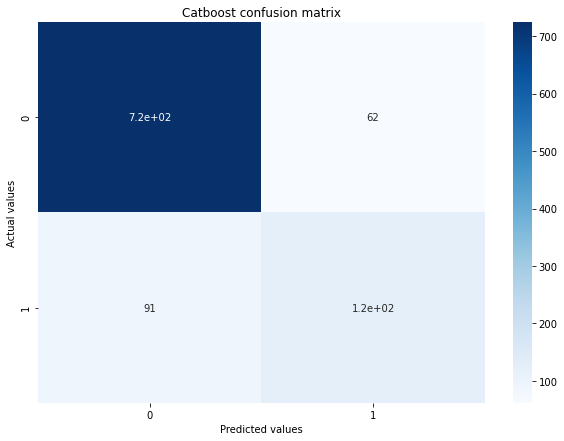

In [47]:
model_CBC = ctb.CatBoostClassifier(random_state=1)
model_CBC.fit(X_train, Y_train)
Y_pred = model_CBC.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Catboost confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

Мы видим значительное улучшение F1-score и AUC-ROC score, особенно в случае Support Vector Classifier.

### SMOTE + Tomek Links

Теперь попробуем другую методику SMOTE + Tomek Links. Это гибридная методика, которая сочетает в себе undersampling and oversampling техники.

In [48]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = train_valid_test_split(data, target = 'Exited', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state = 77)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


counter = Counter(Y_train)
print('Inintial training data',counter)
smote = SMOTETomek()
X_train,Y_train = smote.fit_resample(X_train,Y_train)
counter = Counter(Y_train)
print('After resampling',counter)

Inintial training data Counter({0: 6363, 1: 1637})
After resampling Counter({0: 6260, 1: 6260})


              precision    recall  f1-score   support

           0       0.91      0.79      0.85       786
           1       0.48      0.71      0.57       214

    accuracy                           0.77      1000
   macro avg       0.70      0.75      0.71      1000
weighted avg       0.82      0.77      0.79      1000

AUC - ROC score:  0.7508144871703408


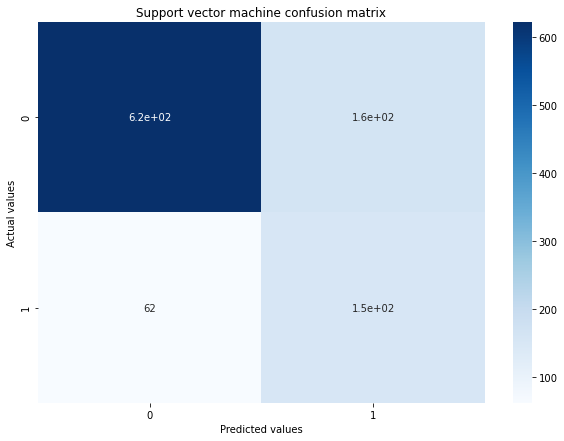

In [49]:
SVM = SVC(random_state = 1)
SVM.fit(X_train, Y_train)
Y_pred = SVM.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Support vector machine confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       786
           1       0.59      0.58      0.59       214

    accuracy                           0.82      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.82      0.82      0.82      1000

AUC - ROC score:  0.7356483793488858


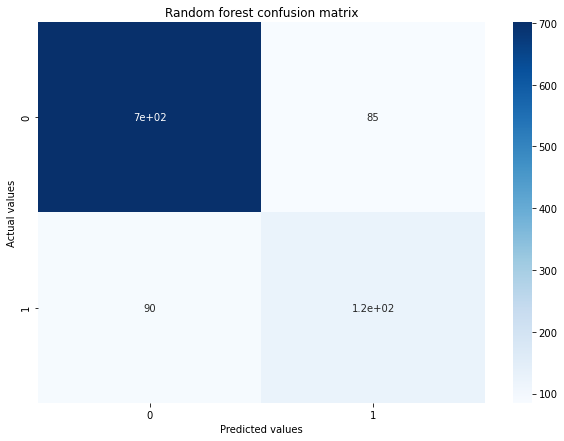

In [50]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random forest confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

Learning rate set to 0.030312
0:	learn: 0.6748753	total: 4.05ms	remaining: 4.04s
1:	learn: 0.6575526	total: 7.81ms	remaining: 3.9s
2:	learn: 0.6430120	total: 11.2ms	remaining: 3.73s
3:	learn: 0.6278982	total: 14.7ms	remaining: 3.65s
4:	learn: 0.6141747	total: 18.3ms	remaining: 3.63s
5:	learn: 0.6033215	total: 21.6ms	remaining: 3.58s
6:	learn: 0.5913501	total: 25.1ms	remaining: 3.56s
7:	learn: 0.5800544	total: 28.6ms	remaining: 3.54s
8:	learn: 0.5700149	total: 32.1ms	remaining: 3.54s
9:	learn: 0.5607404	total: 35.7ms	remaining: 3.53s
10:	learn: 0.5520001	total: 39.1ms	remaining: 3.52s
11:	learn: 0.5434425	total: 42.6ms	remaining: 3.5s
12:	learn: 0.5363070	total: 46.2ms	remaining: 3.5s
13:	learn: 0.5297909	total: 50.9ms	remaining: 3.58s
14:	learn: 0.5228375	total: 55.4ms	remaining: 3.64s
15:	learn: 0.5163144	total: 59.9ms	remaining: 3.68s
16:	learn: 0.5107886	total: 64.3ms	remaining: 3.72s
17:	learn: 0.5056436	total: 69ms	remaining: 3.77s
18:	learn: 0.5017888	total: 73.5ms	remaining: 3.7

184:	learn: 0.2996056	total: 790ms	remaining: 3.48s
185:	learn: 0.2988259	total: 794ms	remaining: 3.48s
186:	learn: 0.2984277	total: 798ms	remaining: 3.47s
187:	learn: 0.2982672	total: 803ms	remaining: 3.47s
188:	learn: 0.2975643	total: 809ms	remaining: 3.47s
189:	learn: 0.2972721	total: 813ms	remaining: 3.46s
190:	learn: 0.2968040	total: 817ms	remaining: 3.46s
191:	learn: 0.2961974	total: 822ms	remaining: 3.46s
192:	learn: 0.2955343	total: 826ms	remaining: 3.45s
193:	learn: 0.2953231	total: 831ms	remaining: 3.45s
194:	learn: 0.2941574	total: 835ms	remaining: 3.44s
195:	learn: 0.2939123	total: 839ms	remaining: 3.44s
196:	learn: 0.2936124	total: 843ms	remaining: 3.44s
197:	learn: 0.2931082	total: 848ms	remaining: 3.44s
198:	learn: 0.2929119	total: 852ms	remaining: 3.43s
199:	learn: 0.2922583	total: 856ms	remaining: 3.42s
200:	learn: 0.2911280	total: 860ms	remaining: 3.42s
201:	learn: 0.2904869	total: 864ms	remaining: 3.42s
202:	learn: 0.2903109	total: 869ms	remaining: 3.41s
203:	learn: 

365:	learn: 0.2343615	total: 1.58s	remaining: 2.74s
366:	learn: 0.2340144	total: 1.58s	remaining: 2.73s
367:	learn: 0.2338362	total: 1.59s	remaining: 2.73s
368:	learn: 0.2335776	total: 1.59s	remaining: 2.73s
369:	learn: 0.2330854	total: 1.6s	remaining: 2.72s
370:	learn: 0.2329077	total: 1.6s	remaining: 2.72s
371:	learn: 0.2325901	total: 1.61s	remaining: 2.71s
372:	learn: 0.2324101	total: 1.61s	remaining: 2.71s
373:	learn: 0.2322359	total: 1.61s	remaining: 2.7s
374:	learn: 0.2320098	total: 1.62s	remaining: 2.7s
375:	learn: 0.2318813	total: 1.62s	remaining: 2.69s
376:	learn: 0.2313898	total: 1.63s	remaining: 2.69s
377:	learn: 0.2312385	total: 1.63s	remaining: 2.68s
378:	learn: 0.2308143	total: 1.63s	remaining: 2.68s
379:	learn: 0.2306840	total: 1.64s	remaining: 2.67s
380:	learn: 0.2305655	total: 1.64s	remaining: 2.67s
381:	learn: 0.2303069	total: 1.65s	remaining: 2.67s
382:	learn: 0.2301969	total: 1.65s	remaining: 2.66s
383:	learn: 0.2300174	total: 1.66s	remaining: 2.66s
384:	learn: 0.22

561:	learn: 0.2013650	total: 2.37s	remaining: 1.85s
562:	learn: 0.2011800	total: 2.37s	remaining: 1.84s
563:	learn: 0.2010298	total: 2.38s	remaining: 1.84s
564:	learn: 0.2009158	total: 2.38s	remaining: 1.83s
565:	learn: 0.2007539	total: 2.38s	remaining: 1.83s
566:	learn: 0.2006225	total: 2.39s	remaining: 1.82s
567:	learn: 0.2005252	total: 2.39s	remaining: 1.82s
568:	learn: 0.2003722	total: 2.4s	remaining: 1.81s
569:	learn: 0.2002259	total: 2.4s	remaining: 1.81s
570:	learn: 0.2000860	total: 2.4s	remaining: 1.81s
571:	learn: 0.1999112	total: 2.41s	remaining: 1.8s
572:	learn: 0.1997883	total: 2.41s	remaining: 1.8s
573:	learn: 0.1997095	total: 2.42s	remaining: 1.79s
574:	learn: 0.1994863	total: 2.42s	remaining: 1.79s
575:	learn: 0.1992760	total: 2.42s	remaining: 1.78s
576:	learn: 0.1991352	total: 2.43s	remaining: 1.78s
577:	learn: 0.1990691	total: 2.43s	remaining: 1.77s
578:	learn: 0.1989684	total: 2.43s	remaining: 1.77s
579:	learn: 0.1988910	total: 2.44s	remaining: 1.76s
580:	learn: 0.198

725:	learn: 0.1842121	total: 2.96s	remaining: 1.12s
726:	learn: 0.1841554	total: 2.97s	remaining: 1.11s
727:	learn: 0.1840510	total: 2.97s	remaining: 1.11s
728:	learn: 0.1839701	total: 2.97s	remaining: 1.1s
729:	learn: 0.1839072	total: 2.98s	remaining: 1.1s
730:	learn: 0.1837752	total: 2.98s	remaining: 1.1s
731:	learn: 0.1837253	total: 2.98s	remaining: 1.09s
732:	learn: 0.1836206	total: 2.99s	remaining: 1.09s
733:	learn: 0.1835711	total: 2.99s	remaining: 1.08s
734:	learn: 0.1834958	total: 2.99s	remaining: 1.08s
735:	learn: 0.1834316	total: 3s	remaining: 1.07s
736:	learn: 0.1833505	total: 3s	remaining: 1.07s
737:	learn: 0.1833084	total: 3s	remaining: 1.07s
738:	learn: 0.1832044	total: 3.01s	remaining: 1.06s
739:	learn: 0.1830474	total: 3.01s	remaining: 1.06s
740:	learn: 0.1829662	total: 3.02s	remaining: 1.05s
741:	learn: 0.1828698	total: 3.02s	remaining: 1.05s
742:	learn: 0.1828130	total: 3.02s	remaining: 1.05s
743:	learn: 0.1827038	total: 3.03s	remaining: 1.04s
744:	learn: 0.1826220	to

892:	learn: 0.1706438	total: 3.55s	remaining: 426ms
893:	learn: 0.1706000	total: 3.56s	remaining: 422ms
894:	learn: 0.1705108	total: 3.56s	remaining: 418ms
895:	learn: 0.1703997	total: 3.57s	remaining: 414ms
896:	learn: 0.1703182	total: 3.57s	remaining: 410ms
897:	learn: 0.1702725	total: 3.57s	remaining: 406ms
898:	learn: 0.1702050	total: 3.58s	remaining: 402ms
899:	learn: 0.1701428	total: 3.58s	remaining: 398ms
900:	learn: 0.1700669	total: 3.58s	remaining: 394ms
901:	learn: 0.1700250	total: 3.59s	remaining: 390ms
902:	learn: 0.1699955	total: 3.59s	remaining: 386ms
903:	learn: 0.1699059	total: 3.59s	remaining: 382ms
904:	learn: 0.1698486	total: 3.6s	remaining: 378ms
905:	learn: 0.1698124	total: 3.6s	remaining: 374ms
906:	learn: 0.1697520	total: 3.6s	remaining: 369ms
907:	learn: 0.1696891	total: 3.61s	remaining: 365ms
908:	learn: 0.1696308	total: 3.61s	remaining: 361ms
909:	learn: 0.1695534	total: 3.61s	remaining: 357ms
910:	learn: 0.1694505	total: 3.62s	remaining: 353ms
911:	learn: 0.1

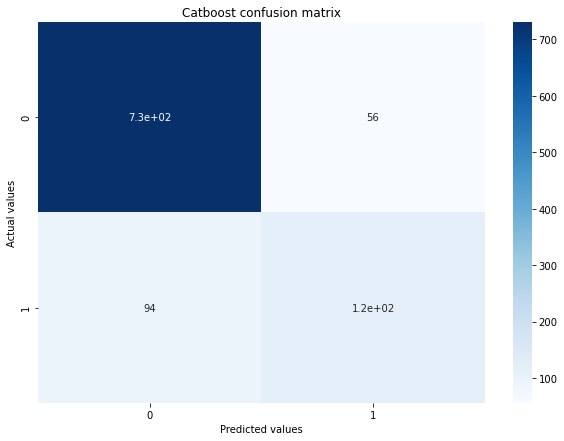

In [51]:
model_CBC = ctb.CatBoostClassifier(random_state=1)
model_CBC.fit(X_train, Y_train)
Y_pred = model_CBC.predict(X_valid)

cm = confusion_matrix(Y_valid, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Catboost confusion matrix')

print(classification_report(Y_valid,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_valid,Y_pred))

Результаты оказались хуже, чем при использовании простого SMOTE, однако в любом случае результат для Support Vector Classifier значительно лучше, чем при несбалансированности.

## Тестирование модели

Запустим модель с наилучшими показателями (Catboost) на тестовом наборе.

Learning rate set to 0.030524
0:	learn: 0.6758319	total: 4.69ms	remaining: 4.69s
1:	learn: 0.6593814	total: 9.19ms	remaining: 4.59s
2:	learn: 0.6447509	total: 13.4ms	remaining: 4.44s
3:	learn: 0.6305233	total: 18.1ms	remaining: 4.51s
4:	learn: 0.6170086	total: 22.4ms	remaining: 4.47s
5:	learn: 0.6053525	total: 26.7ms	remaining: 4.42s
6:	learn: 0.5940318	total: 31.1ms	remaining: 4.41s
7:	learn: 0.5828237	total: 35.5ms	remaining: 4.41s
8:	learn: 0.5729331	total: 39.8ms	remaining: 4.38s
9:	learn: 0.5638097	total: 43.9ms	remaining: 4.35s
10:	learn: 0.5552356	total: 48.4ms	remaining: 4.36s
11:	learn: 0.5467743	total: 52.8ms	remaining: 4.34s
12:	learn: 0.5390678	total: 57.2ms	remaining: 4.34s
13:	learn: 0.5323184	total: 61.5ms	remaining: 4.33s
14:	learn: 0.5263043	total: 65.8ms	remaining: 4.32s
15:	learn: 0.5202136	total: 70.4ms	remaining: 4.33s
16:	learn: 0.5149981	total: 74.8ms	remaining: 4.32s
17:	learn: 0.5103018	total: 79.3ms	remaining: 4.32s
18:	learn: 0.5049707	total: 83.9ms	remaining

183:	learn: 0.3023688	total: 793ms	remaining: 3.51s
184:	learn: 0.3020838	total: 797ms	remaining: 3.51s
185:	learn: 0.3018220	total: 804ms	remaining: 3.52s
186:	learn: 0.3016422	total: 808ms	remaining: 3.51s
187:	learn: 0.3010979	total: 813ms	remaining: 3.51s
188:	learn: 0.3008917	total: 817ms	remaining: 3.51s
189:	learn: 0.3007483	total: 822ms	remaining: 3.5s
190:	learn: 0.3005140	total: 826ms	remaining: 3.5s
191:	learn: 0.2991147	total: 830ms	remaining: 3.49s
192:	learn: 0.2984974	total: 835ms	remaining: 3.49s
193:	learn: 0.2979590	total: 839ms	remaining: 3.48s
194:	learn: 0.2976450	total: 843ms	remaining: 3.48s
195:	learn: 0.2967782	total: 847ms	remaining: 3.48s
196:	learn: 0.2964167	total: 851ms	remaining: 3.47s
197:	learn: 0.2950881	total: 855ms	remaining: 3.46s
198:	learn: 0.2946620	total: 859ms	remaining: 3.46s
199:	learn: 0.2944368	total: 863ms	remaining: 3.45s
200:	learn: 0.2941839	total: 867ms	remaining: 3.45s
201:	learn: 0.2931650	total: 872ms	remaining: 3.44s
202:	learn: 0.

364:	learn: 0.2415194	total: 1.58s	remaining: 2.75s
365:	learn: 0.2413798	total: 1.58s	remaining: 2.74s
366:	learn: 0.2408421	total: 1.59s	remaining: 2.74s
367:	learn: 0.2407192	total: 1.59s	remaining: 2.73s
368:	learn: 0.2403914	total: 1.6s	remaining: 2.73s
369:	learn: 0.2400154	total: 1.6s	remaining: 2.73s
370:	learn: 0.2399073	total: 1.61s	remaining: 2.73s
371:	learn: 0.2397982	total: 1.61s	remaining: 2.72s
372:	learn: 0.2395888	total: 1.62s	remaining: 2.72s
373:	learn: 0.2392461	total: 1.62s	remaining: 2.71s
374:	learn: 0.2391520	total: 1.62s	remaining: 2.71s
375:	learn: 0.2389663	total: 1.63s	remaining: 2.7s
376:	learn: 0.2387618	total: 1.63s	remaining: 2.7s
377:	learn: 0.2382745	total: 1.64s	remaining: 2.69s
378:	learn: 0.2380161	total: 1.64s	remaining: 2.69s
379:	learn: 0.2378900	total: 1.65s	remaining: 2.69s
380:	learn: 0.2377874	total: 1.65s	remaining: 2.68s
381:	learn: 0.2377030	total: 1.66s	remaining: 2.68s
382:	learn: 0.2375316	total: 1.66s	remaining: 2.67s
383:	learn: 0.23

542:	learn: 0.2133690	total: 2.37s	remaining: 1.99s
543:	learn: 0.2131787	total: 2.37s	remaining: 1.99s
544:	learn: 0.2130631	total: 2.37s	remaining: 1.98s
545:	learn: 0.2129319	total: 2.38s	remaining: 1.98s
546:	learn: 0.2127397	total: 2.38s	remaining: 1.97s
547:	learn: 0.2125905	total: 2.39s	remaining: 1.97s
548:	learn: 0.2124242	total: 2.39s	remaining: 1.96s
549:	learn: 0.2123049	total: 2.4s	remaining: 1.96s
550:	learn: 0.2121358	total: 2.4s	remaining: 1.96s
551:	learn: 0.2120605	total: 2.4s	remaining: 1.95s
552:	learn: 0.2119885	total: 2.41s	remaining: 1.95s
553:	learn: 0.2119296	total: 2.41s	remaining: 1.94s
554:	learn: 0.2118639	total: 2.42s	remaining: 1.94s
555:	learn: 0.2117110	total: 2.42s	remaining: 1.93s
556:	learn: 0.2116418	total: 2.43s	remaining: 1.93s
557:	learn: 0.2115657	total: 2.43s	remaining: 1.93s
558:	learn: 0.2115140	total: 2.44s	remaining: 1.92s
559:	learn: 0.2113750	total: 2.44s	remaining: 1.92s
560:	learn: 0.2113174	total: 2.44s	remaining: 1.91s
561:	learn: 0.2

727:	learn: 0.1940370	total: 3.15s	remaining: 1.18s
728:	learn: 0.1939614	total: 3.16s	remaining: 1.17s
729:	learn: 0.1939108	total: 3.16s	remaining: 1.17s
730:	learn: 0.1938102	total: 3.17s	remaining: 1.17s
731:	learn: 0.1936939	total: 3.17s	remaining: 1.16s
732:	learn: 0.1935605	total: 3.17s	remaining: 1.16s
733:	learn: 0.1934327	total: 3.18s	remaining: 1.15s
734:	learn: 0.1933901	total: 3.18s	remaining: 1.15s
735:	learn: 0.1933332	total: 3.19s	remaining: 1.14s
736:	learn: 0.1931832	total: 3.19s	remaining: 1.14s
737:	learn: 0.1930846	total: 3.2s	remaining: 1.14s
738:	learn: 0.1930176	total: 3.2s	remaining: 1.13s
739:	learn: 0.1928705	total: 3.21s	remaining: 1.13s
740:	learn: 0.1926750	total: 3.21s	remaining: 1.12s
741:	learn: 0.1925837	total: 3.21s	remaining: 1.12s
742:	learn: 0.1925052	total: 3.22s	remaining: 1.11s
743:	learn: 0.1924702	total: 3.22s	remaining: 1.11s
744:	learn: 0.1924125	total: 3.23s	remaining: 1.1s
745:	learn: 0.1923643	total: 3.23s	remaining: 1.1s
746:	learn: 0.19

906:	learn: 0.1781663	total: 3.95s	remaining: 405ms
907:	learn: 0.1781023	total: 3.95s	remaining: 400ms
908:	learn: 0.1780744	total: 3.95s	remaining: 396ms
909:	learn: 0.1780040	total: 3.96s	remaining: 392ms
910:	learn: 0.1779387	total: 3.96s	remaining: 387ms
911:	learn: 0.1778863	total: 3.97s	remaining: 383ms
912:	learn: 0.1778296	total: 3.97s	remaining: 378ms
913:	learn: 0.1777911	total: 3.98s	remaining: 374ms
914:	learn: 0.1777507	total: 3.98s	remaining: 370ms
915:	learn: 0.1776884	total: 3.98s	remaining: 365ms
916:	learn: 0.1776403	total: 3.99s	remaining: 361ms
917:	learn: 0.1775521	total: 3.99s	remaining: 357ms
918:	learn: 0.1774700	total: 4s	remaining: 352ms
919:	learn: 0.1774108	total: 4s	remaining: 348ms
920:	learn: 0.1773463	total: 4.01s	remaining: 344ms
921:	learn: 0.1772755	total: 4.01s	remaining: 339ms
922:	learn: 0.1772043	total: 4.01s	remaining: 335ms
923:	learn: 0.1771524	total: 4.02s	remaining: 331ms
924:	learn: 0.1771181	total: 4.02s	remaining: 326ms
925:	learn: 0.1770

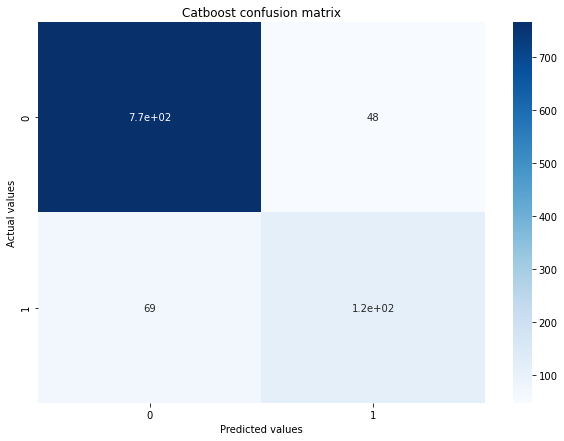

In [52]:
#Split the data into train, validation and test sets
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = train_valid_test_split(data, target = 'Exited', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state = 77)

#Standartization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

#Apply SMOTE
counter = Counter(Y_train)
smote = SMOTE()
X_train,Y_train = smote.fit_resample(X_train,Y_train)
counter = Counter(Y_train)

#Implement the model
model_CBC = ctb.CatBoostClassifier(random_state=1)
model_CBC.fit(X_train, Y_train)
Y_pred = model_CBC.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Catboost confusion matrix')

print(classification_report(Y_test,Y_pred))
print('AUC - ROC score: ',roc_auc_score(Y_test,Y_pred))

Посмотрим какие переменные оказали наибольшее влияние при построении модели.

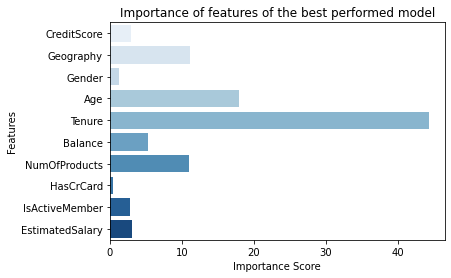

In [53]:
data1 = data.drop(['Exited'], axis = 'columns')

feature_imp = model_CBC.feature_importances_
sns.barplot(x = feature_imp, y = data1.columns, palette='Blues')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Importance of features of the best performed model')
plt.show()

Таким образом, наибольший вес имели:
- количество лет, в течение которых человек являлся клиентом банка;
- возраст;
- количество используемых продуктов;
- география;
- баланс на счёте.

Модель Catboost позволяет нам предсказать уход клиента с точностью 89%, F1 равным 0.67 и AUC-ROC score - 0.79. Эти показатели потенциально можно улучшить:

- применяя k-fold cross-validation;
- используя другие методики машинного обучения, например XGBoost;
- используя алгоритмы глубокого обучения, например ANN или LSTM;
- удалив одну или более малозначительных переменных;
- используя hyperparameters tuning.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*